# Time series analysis for Automobiles Sales in US

In [215]:

"""Automobiles Sales Time Series Analysis"""
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp, boxcox
import warnings
warnings.filterwarnings('ignore')

In [205]:
# Loading and preparing the data
df = pd.read_csv('us_retail.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
sales_data = df[['Automobiles', 'GeneralMerchandise', 'FoodAndBeverage', 'Clothing', 'Appliances', 'BuildingMaterials']].copy()

# Exploratory Data Analysis (EDA)

In [208]:

# 1. Summary Statistics
print("Summary Statistics for Retail Sales Data:")
print(sales_data.describe())


Summary Statistics for Retail Sales Data:
         Automobiles  GeneralMerchandise  FoodAndBeverage      Clothing  \
count     336.000000          336.000000       336.000000    336.000000   
mean    63576.413690        42382.071429     44668.348214  16414.744048   
std     17459.092725        14372.343480     10444.196145   5477.293118   
min     26788.000000        14996.000000     28126.000000   6938.000000   
25%     51374.750000        30178.500000     35517.000000  12335.500000   
50%     62704.000000        44168.000000     42932.500000  15894.500000   
75%     74202.500000        53058.250000     52877.000000  19889.750000   
max    105884.000000        78716.000000     70028.000000  35157.000000   

         Appliances  BuildingMaterials  
count    336.000000         336.000000  
mean    7569.285714       21938.934524  
std     1993.569861        6470.241055  
min     3490.000000        8947.000000  
25%     6654.750000       16833.750000  
50%     7414.000000       21949.5000

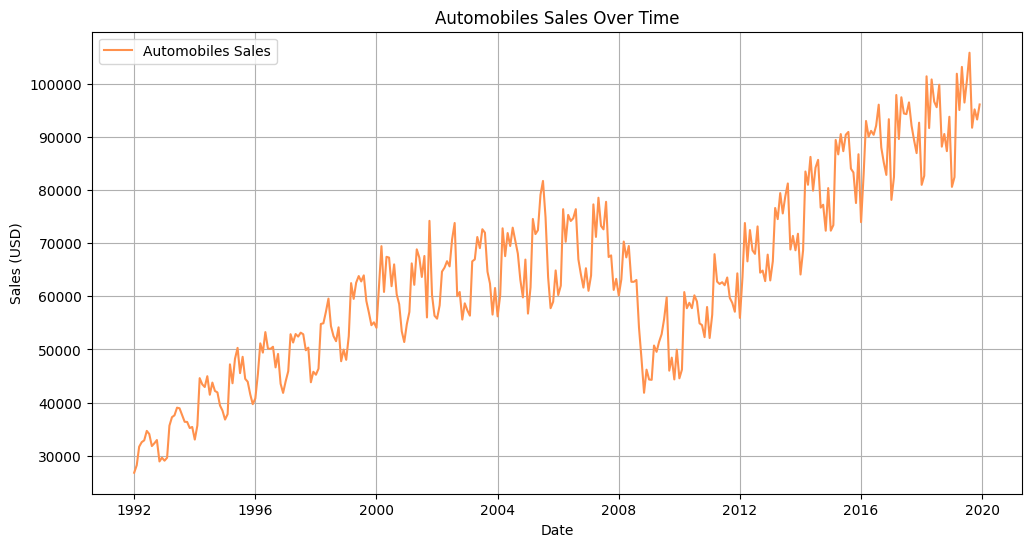

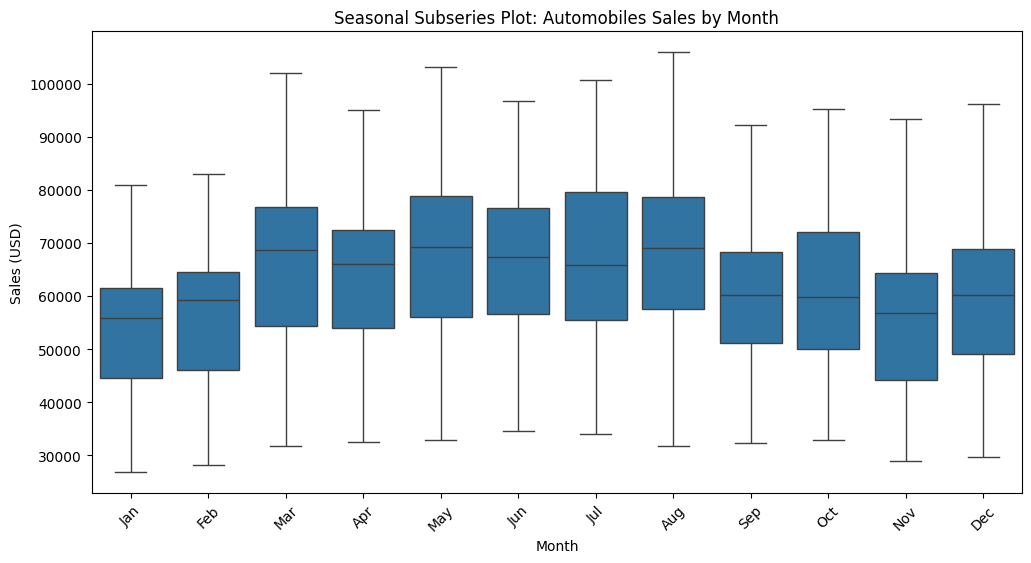

In [209]:
# 2. Time Series Plot for Automobiles
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data['Automobiles'], label='Automobiles Sales', color='#FF914D')
plt.title('Automobiles Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Seasonal Subseries Plot
sales_data['Month_Name'] = sales_data.index.strftime('%b')
sales_data['Year'] = sales_data.index.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month_Name', y='Automobiles', data=sales_data)
plt.title('Seasonal Subseries Plot: Automobiles Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales (USD)')
plt.xticks(rotation=45)
plt.show()


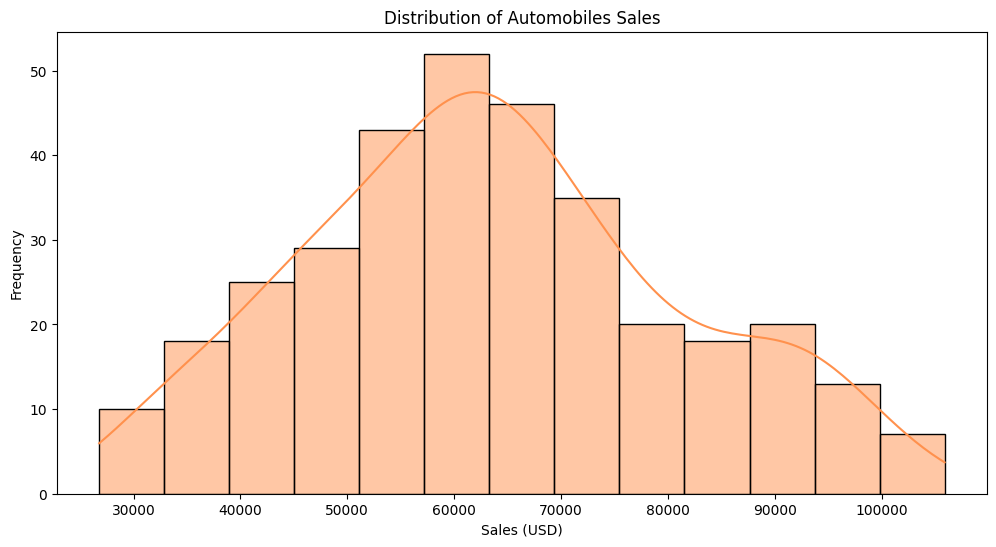

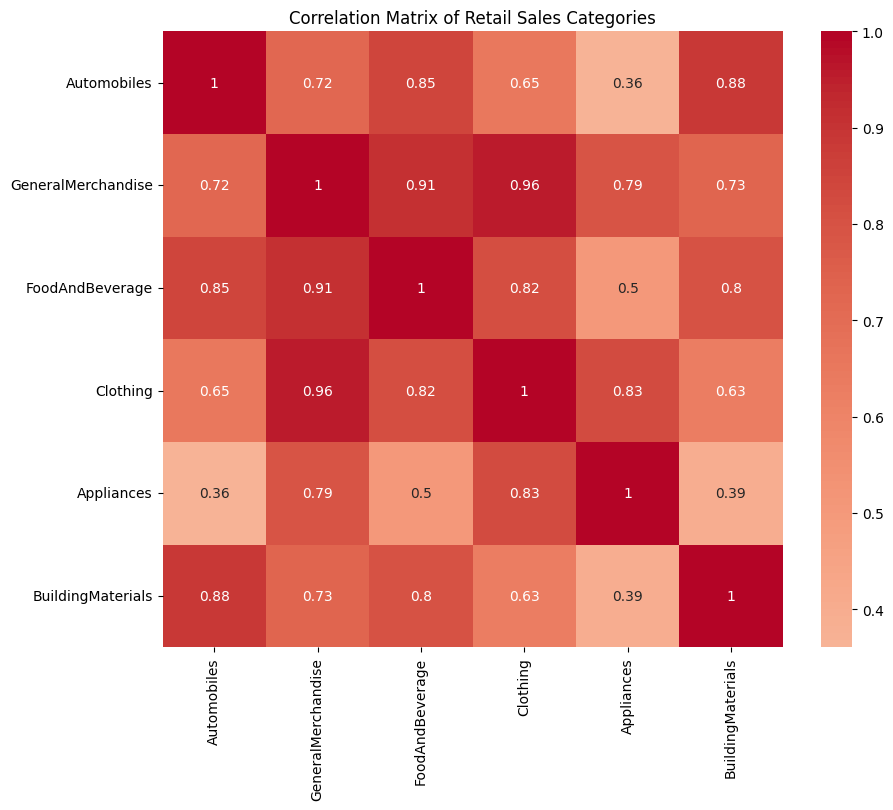

In [210]:
# 4. Distribution Analysis
plt.figure(figsize=(12, 6))
sns.histplot(sales_data['Automobiles'], kde=True, color='#FF914D')
plt.title('Distribution of Automobiles Sales')
plt.xlabel('Sales (USD)')
plt.ylabel('Frequency')
plt.show()

# 5. Correlation Analysis
plt.figure(figsize=(10, 8))
correlation_matrix = sales_data[['Automobiles', 'GeneralMerchandise', 'FoodAndBeverage', 'Clothing', 'Appliances', 'BuildingMaterials']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Retail Sales Categories')
plt.show()


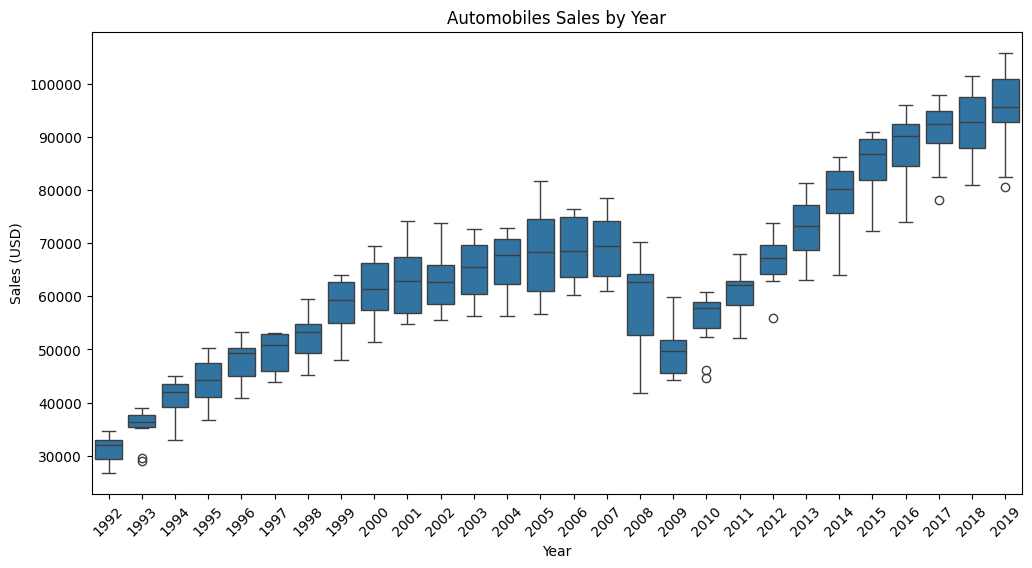

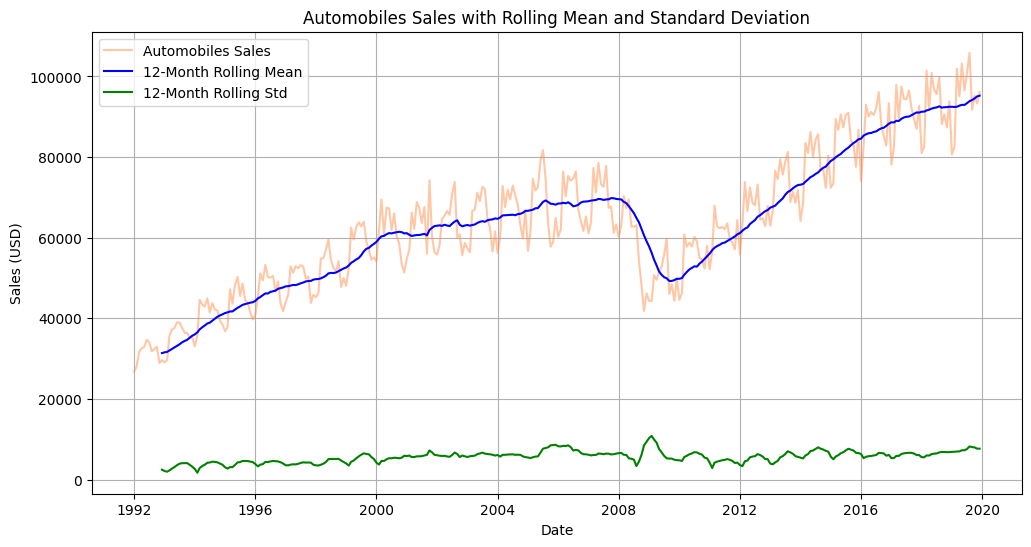

In [211]:
# 6. Box Plot by Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Automobiles', data=sales_data)
plt.title('Automobiles Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.xticks(rotation=45)
plt.show()

# 7. Rolling Statistics
window = 12
sales_data['Rolling_Mean'] = sales_data['Automobiles'].rolling(window=window).mean()
sales_data['Rolling_Std'] = sales_data['Automobiles'].rolling(window=window).std()

plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data['Automobiles'], label='Automobiles Sales', color='#FF914D', alpha=0.5)
plt.plot(sales_data.index, sales_data['Rolling_Mean'], label='12-Month Rolling Mean', color='blue')
plt.plot(sales_data.index, sales_data['Rolling_Std'], label='12-Month Rolling Std', color='green')
plt.title('Automobiles Sales with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Drop temporary columns used for EDA
sales_data.drop(['Month_Name', 'Year', 'Rolling_Mean', 'Rolling_Std'], axis=1, inplace=True)

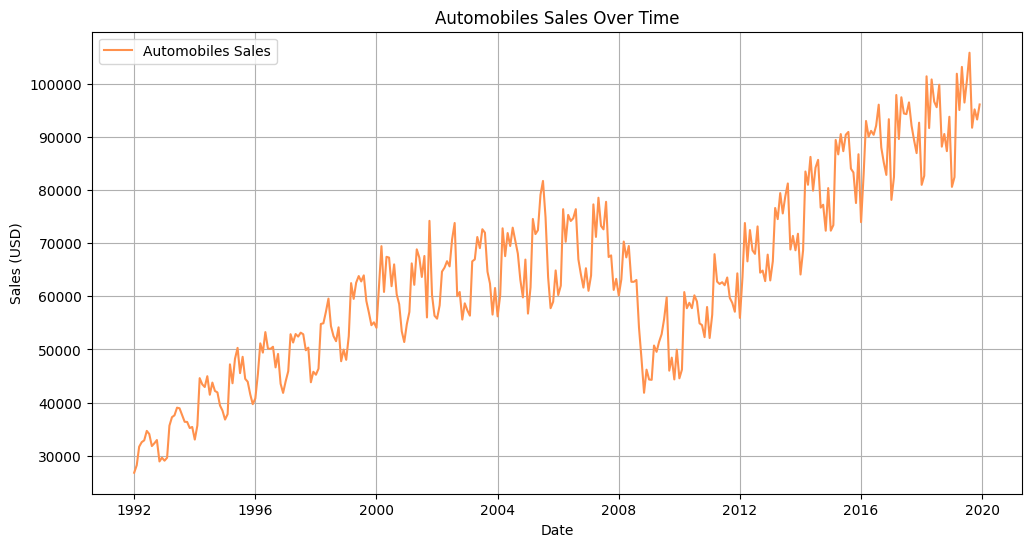

In [212]:

# Plotting the original Automobiles sales data
plt.figure(figsize=(12,6))
plt.plot(sales_data.index, sales_data['Automobiles'], label='Automobiles Sales', color='#FF914D')
plt.title('Automobiles Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Checking stationarity with ADF and KPSS tests

In [213]:
# Checking stationarity with ADF and KPSS tests
def adf_test(series):
    result = adfuller(series)
    print('--------------------ADF Test Results-----------------------------:')
    print(f'ADF Statistic: {round(result[0], 3)}')
    print(f'p-value: {round(result[1], 3)}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {round(value, 3)}')

def kpss_test(series):
    result = kpss(series, regression='ct')
    print('---------------------KPSS Test Results---------------------------:')
    print(f'KPSS Statistic: {round(result[0], 2)}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'  {key}: {value}')

print("Stationarity Test for Automobiles Sales:")
adf_test(sales_data['Automobiles'])
kpss_test(sales_data['Automobiles'])

Stationarity Test for Automobiles Sales:
--------------------ADF Test Results-----------------------------:
ADF Statistic: -1.099
p-value: 0.716
Critical Values:
  1%: -3.451
  5%: -2.871
  10%: -2.572
---------------------KPSS Test Results---------------------------:
KPSS Statistic: 0.31
p-value: 0.01
Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216


# Transforming Data

In [151]:
# Transforming data to make it stationary
sales_diff = sales_data['Automobiles'].diff().dropna()  # First differencing
print("\nStationarity Test for Differenced Automobiles Sales:")
adf_test(sales_diff)
kpss_test(sales_diff)

# Log transformation (handling positive values)
sales_log = np.log(sales_data['Automobiles'][sales_data['Automobiles'] > 0])
print("\nStationarity Test for Log-Transformed Automobiles Sales:")
adf_test(sales_log)
kpss_test(sales_log)

pricesss = sales_data['Automobiles']

# Square root transformation
prices_sqrt = np.sqrt(pricesss)

# Box-Cox transformation
# Ensure prices are a NumPy array
prices_array = np.array(pricesss)
# Filter only positive prices (Box-Cox requires positive values)
positive_prices = prices_array[prices_array > 0]
# Apply Box-Cox transformation
prices_boxcox, lam = stats.boxcox(positive_prices)
print("\nStationarity Test for SQRT-Transformed Automobiles Sales:")
adf_test(prices_sqrt)
print("\nStationarity Test for boxcox-Transformed Automobiles Sales:")
kpss_test(prices_boxcox)


Stationarity Test for Differenced Automobiles Sales:
--------------------ADF Test Results-----------------------------:
ADF Statistic: -3.208
p-value: 0.02
Critical Values:
  1%: -3.451
  5%: -2.871
  10%: -2.572
---------------------KPSS Test Results---------------------------:
KPSS Statistic: 0.02
p-value: 0.1
Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216

Stationarity Test for Log-Transformed Automobiles Sales:
--------------------ADF Test Results-----------------------------:
ADF Statistic: -1.661
p-value: 0.451
Critical Values:
  1%: -3.451
  5%: -2.871
  10%: -2.572
---------------------KPSS Test Results---------------------------:
KPSS Statistic: 0.33
p-value: 0.01
Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216

Stationarity Test for SQRT-Transformed Automobiles Sales:
--------------------ADF Test Results-----------------------------:
ADF Statistic: -1.334
p-value: 0.614
Critical Values:
  1%: -3.451
  5%: -2.871
  10%: -2.572

Station

# Classical Decomposition (Additive)

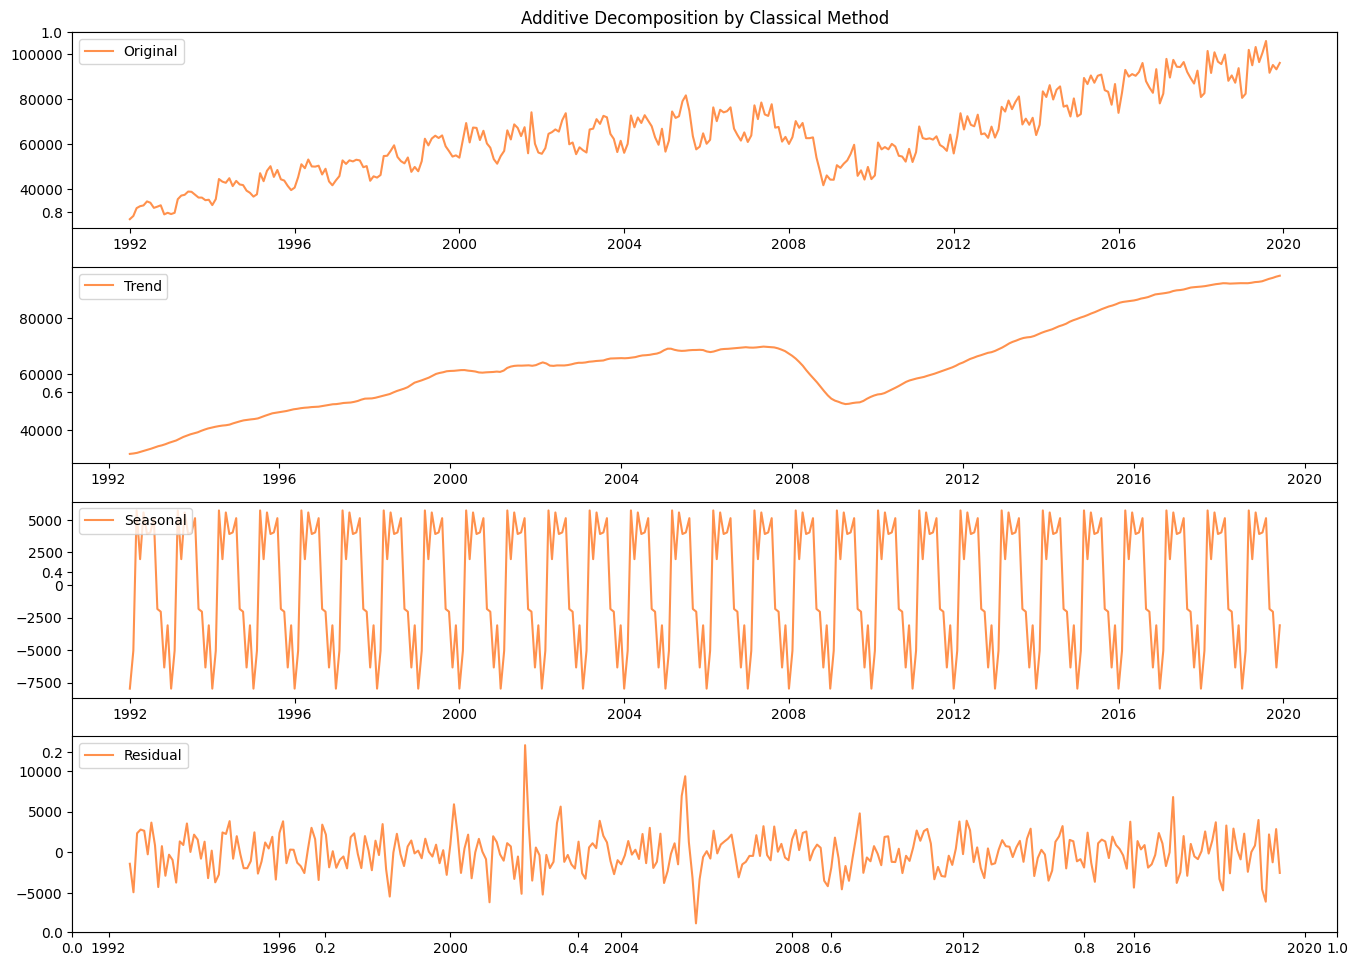

In [152]:
# Using differenced data for modeling (assuming it's more stationary)
prices = sales_diff

# Classical Decomposition (Additive)
decomposition_additive = seasonal_decompose(sales_data['Automobiles'], model='additive', period=12)
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

plt.figure(figsize=(14,10))
plt.title("Additive Decomposition by Classical Method")
plt.subplot(411)
plt.plot(sales_data['Automobiles'], label='Original', color='#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color='#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color='#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color='#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# STL Decomposition

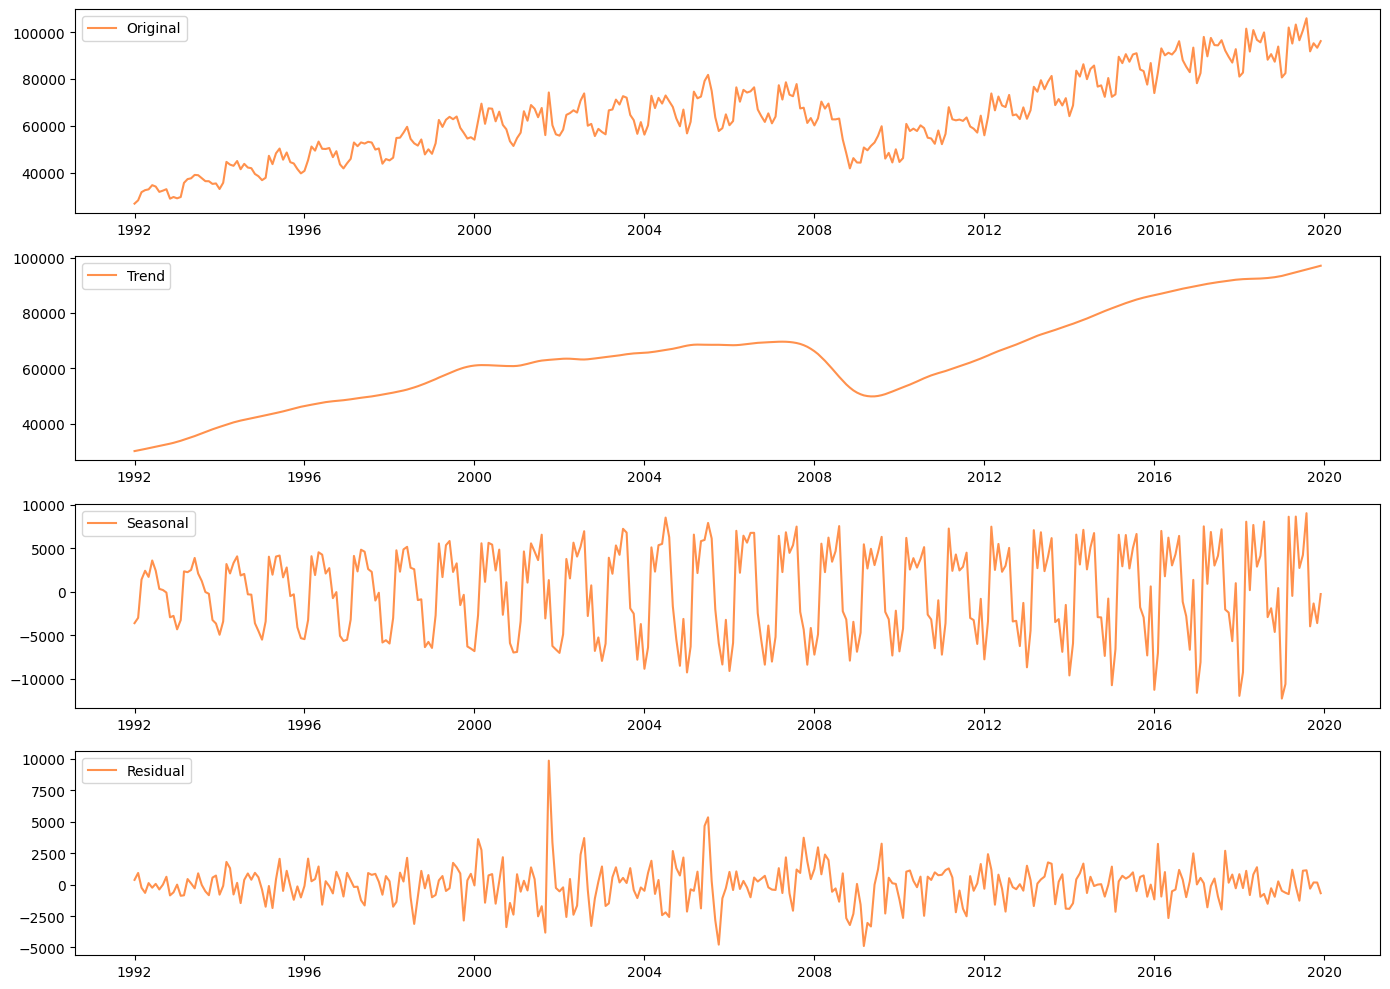

In [153]:
# STL Decomposition
stl = STL(sales_data['Automobiles'], period=12)
decomposition_stl = stl.fit()
trend_stl = decomposition_stl.trend
seasonal_stl = decomposition_stl.seasonal
residual_stl = decomposition_stl.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(sales_data['Automobiles'], label='Original', color='#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_stl, label='Trend', color='#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_stl, label='Seasonal', color='#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_stl, label='Residual', color='#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# KS Test for Stationarity

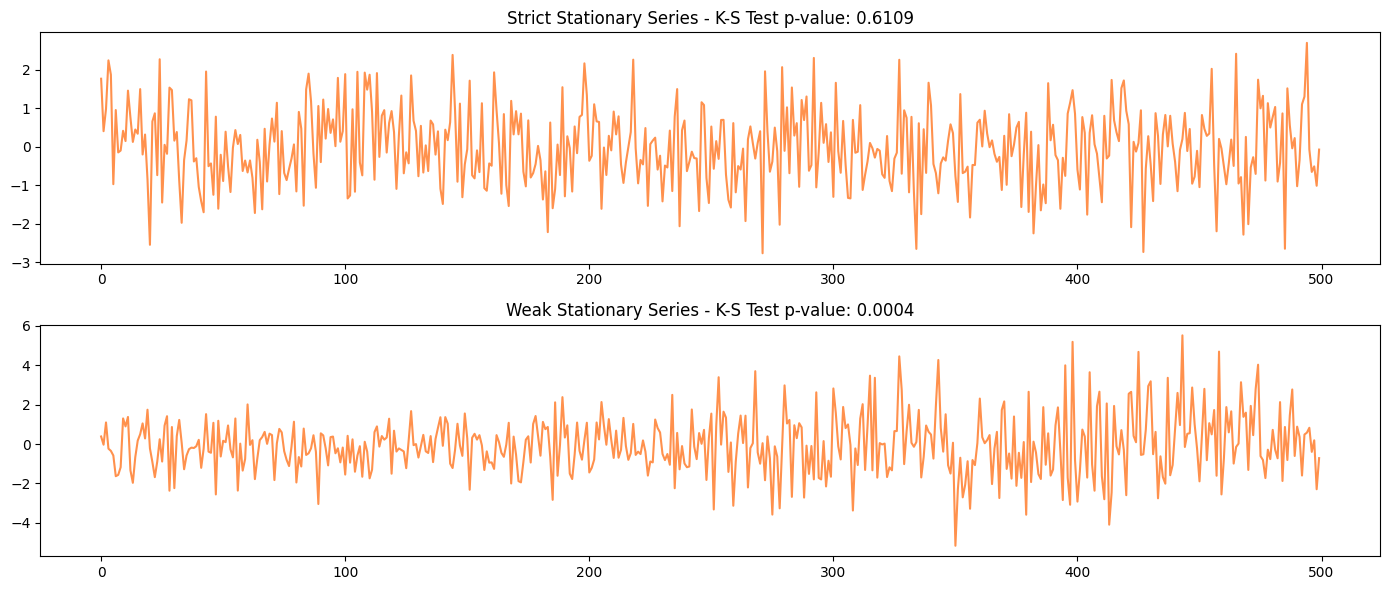

Strict Stationary Series - K-S Test Statistic: 0.068, p-value: 0.6109
Weak Stationary Series - K-S Test Statistic: 0.184, p-value: 0.0004


In [133]:
# KS Test for Stationarity
np.random.seed(0)
n = 500
strict_stationary_series = np.random.normal(0, 1, n)
non_strict_stationary_series = np.concatenate([
    np.random.normal(0, 1, n // 2),
    np.random.normal(0, 2, n // 2)
])

def ks_test_stationarity(series):
    split = len(series) // 2
    series_first_half = series[:split]
    series_second_half = series[split:]
    stat, p_value = ks_2samp(series_first_half, series_second_half)
    return stat, p_value

ks_stat_strict, ks_pvalue_strict = ks_test_stationarity(strict_stationary_series)
ks_stat_non_strict, ks_pvalue_non_strict = ks_test_stationarity(non_strict_stationary_series)

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(strict_stationary_series, color='#FF914D')
plt.title(f'Strict Stationary Series - K-S Test p-value: {ks_pvalue_strict:.4f}')
plt.subplot(2, 1, 2)
plt.plot(non_strict_stationary_series, color='#FF914D')
plt.title(f'Weak Stationary Series - K-S Test p-value: {ks_pvalue_non_strict:.4f}')
plt.tight_layout()
plt.show()

print(f'Strict Stationary Series - K-S Test Statistic: {ks_stat_strict}, p-value: {ks_pvalue_strict:.4f}')
print(f'Weak Stationary Series - K-S Test Statistic: {ks_stat_non_strict}, p-value: {ks_pvalue_non_strict:.4f}')

# Detrending

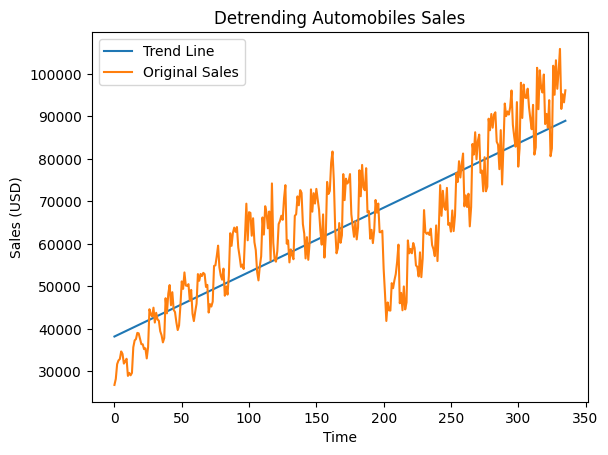

In [154]:
# Detrending
prices_array = np.array(sales_data['Automobiles'])
trend = np.polyfit(np.arange(len(prices_array)), prices_array, 1)
trendline = np.polyval(trend, np.arange(len(prices_array)))
prices_detrended = prices_array - trendline

plt.plot(np.arange(len(prices_array)), trendline, label='Trend Line')
plt.plot(np.arange(len(prices_array)), prices_array, label='Original Sales')
plt.title('Detrending Automobiles Sales')
plt.xlabel('Time')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()

# White Noise and Random Walk

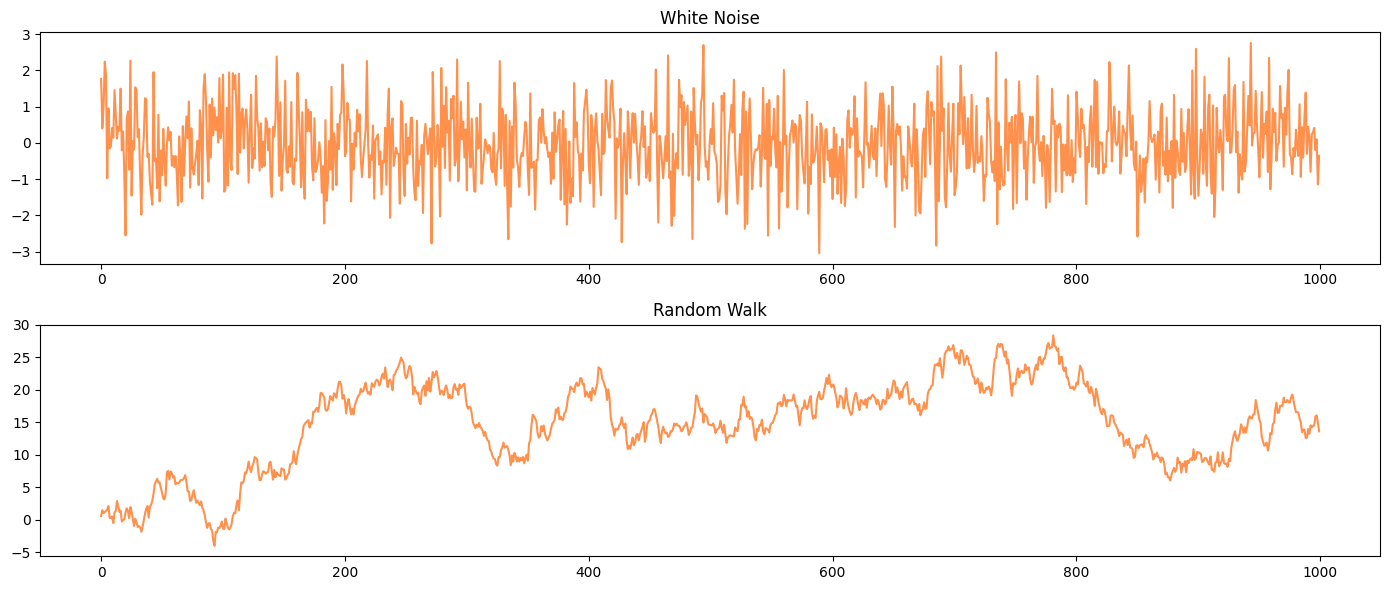

In [135]:

# White Noise and Random Walk
np.random.seed(0)
n = 1000
white_noise = np.random.normal(0, 1, n)
random_shocks = np.random.normal(0, 1, n)
random_walk = np.cumsum(random_shocks)

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(white_noise, color='#FF914D')
plt.title('White Noise')
plt.subplot(2, 1, 2)
plt.plot(random_walk, color='#FF914D')
plt.title('Random Walk')
plt.tight_layout()
plt.show()

# Ljung-Box Test

In [136]:
# Ljung-Box Test
print("Ljung-Box Test for White Noise:")
lb_test_white_noise = acorr_ljungbox(white_noise, lags=[10], return_df=True)
print(lb_test_white_noise)
print("\nLjung-Box Test for Random Walk:")
lb_test_random_walk = acorr_ljungbox(random_walk, lags=[10], return_df=True)
print(lb_test_random_walk)

Ljung-Box Test for White Noise:
      lb_stat  lb_pvalue
10  14.025574   0.171828

Ljung-Box Test for Random Walk:
        lb_stat  lb_pvalue
10  8828.660312        0.0


# AR Model

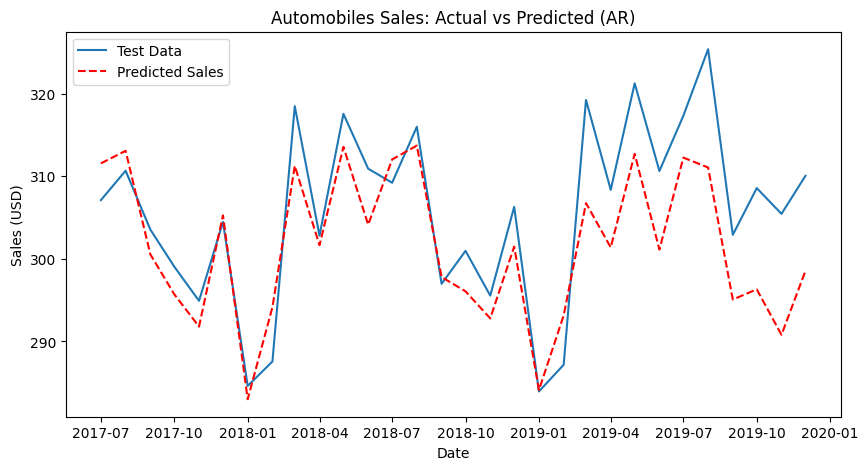

RMSE_AR: 7.03


In [159]:
# Model Fitting (using differenced data)

train_data = prices_sqrt[:-30]
test_data = prices_sqrt[-30:]


# train_data = sales_log[:-150]
# test_data = sales_log[-150:]

# AR Model
model_ar = AutoReg(train_data, lags=30)
model_fit_ar = model_ar.fit()
predictions_ar = model_fit_ar.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions_ar, color='red', linestyle='--', label='Predicted Sales')
plt.title('Automobiles Sales: Actual vs Predicted (AR)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_ar = round(np.sqrt(mean_squared_error(test_data, predictions_ar)), 2)
print('RMSE_AR:', rmse_ar)

# MA Model

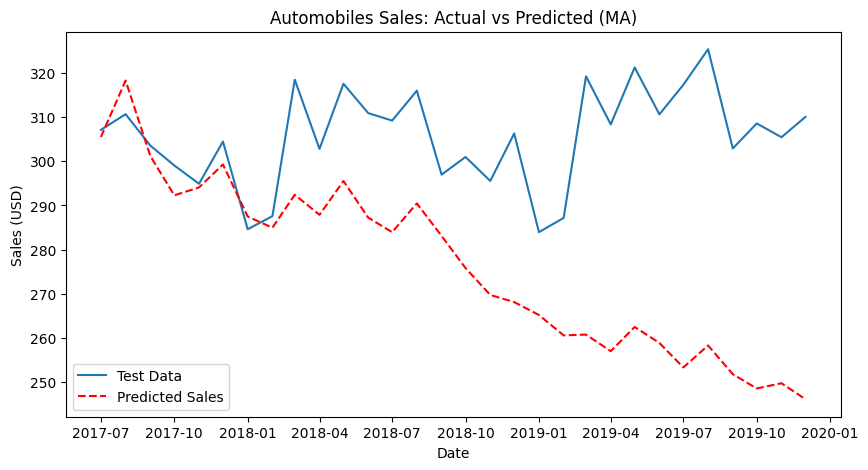

RMSE_MA: 37.26


In [160]:
# MA Model
model_ma = ARIMA(train_data, order=(0, 0, 30))
model_fit_ma = model_ma.fit()
predictions_ma = model_fit_ma.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions_ma, color='red', linestyle='--', label='Predicted Sales')
plt.title('Automobiles Sales: Actual vs Predicted (MA)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_ma = round(np.sqrt(mean_squared_error(test_data, predictions_ma)), 2)
print('RMSE_MA:', rmse_ma)

# ARMA Model

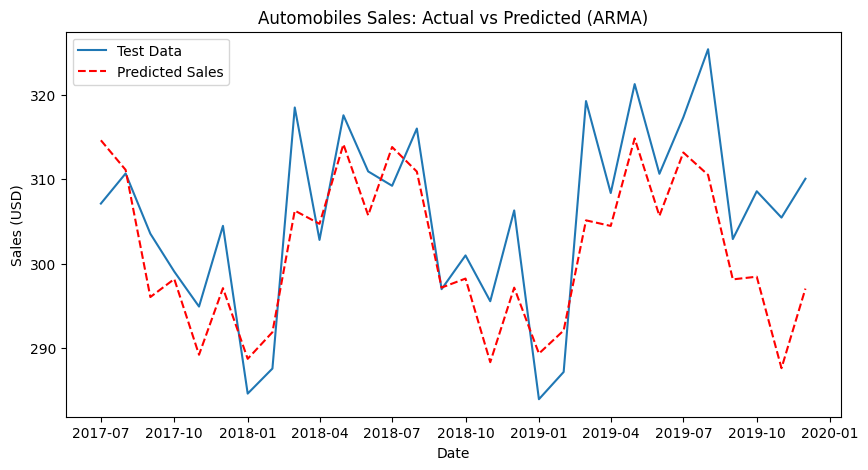

RMSE_ARMA: 7.75


In [161]:
# ARMA Model
model_arma = ARIMA(train_data, order=(7, 0, 7))
model_fit_arma = model_arma.fit()
predictions_arma = model_fit_arma.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions_arma, color='red', linestyle='--', label='Predicted Sales')
plt.title('Automobiles Sales: Actual vs Predicted (ARMA)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_arma = round(np.sqrt(mean_squared_error(test_data, predictions_arma)), 2)
print('RMSE_ARMA:', rmse_arma)

# ARIMA Model

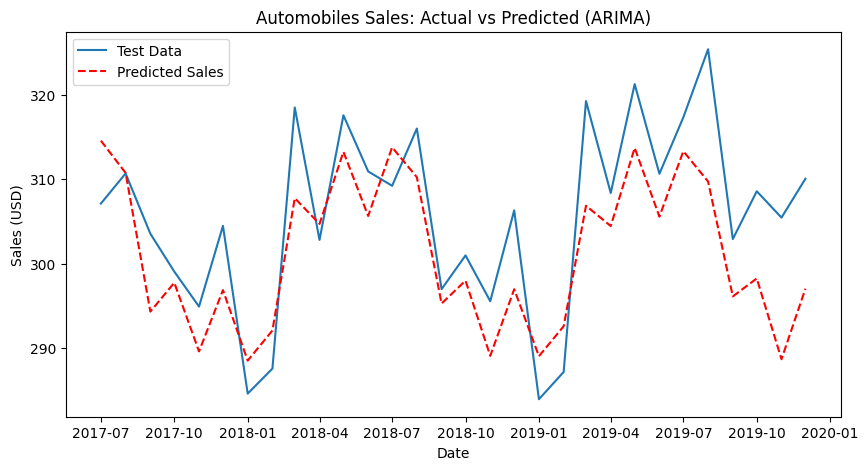

RMSE_ARIMA: 7.74


In [162]:
# ARIMA Model
model_arima = ARIMA(train_data, order=(7, 1, 7))
model_fit_arima = model_arima.fit()
predictions_arima = model_fit_arima.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions_arima, color='red', linestyle='--', label='Predicted Sales')
plt.title('Automobiles Sales: Actual vs Predicted (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_arima = round(np.sqrt(mean_squared_error(test_data, predictions_arima)), 2)
print('RMSE_ARIMA:', rmse_arima)

# SARIMA Model

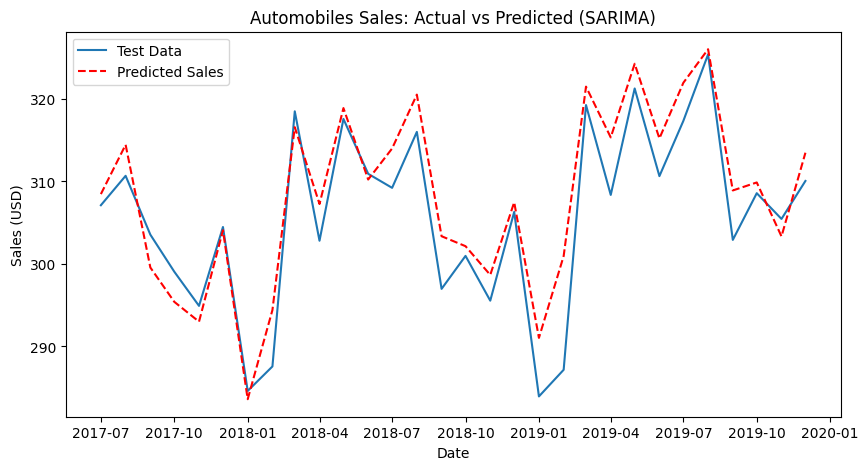

RMSE_SARIMA: 4.54


In [163]:
# SARIMA Model
p, d, q = 7, 1, 7
P, D, Q, s = 1, 1, 1, 12
model_sarima = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()
predictions_sarima = model_fit_sarima.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    dynamic=False
)

plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, predictions_sarima, color='red', linestyle='--', label='Predicted Sales')
plt.title('Automobiles Sales: Actual vs Predicted (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_sarima = round(np.sqrt(mean_squared_error(test_data, predictions_sarima)), 2)
print('RMSE_SARIMA:', rmse_sarima)

# Granger Causality Test

In [164]:
# Granger Causality Test
sales_data['Auto_Shifted'] = sales_data['Automobiles'].shift()
sales_data.dropna(inplace=True)
grangercausalitytests(sales_data[['Auto_Shifted', 'GeneralMerchandise']].dropna(), maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.2137 , p=0.0000  , df_denom=331, df_num=1
ssr based chi2 test:   chi2=28.4694 , p=0.0000  , df=1
likelihood ratio test: chi2=27.3209 , p=0.0000  , df=1
parameter F test:         F=28.2137 , p=0.0000  , df_denom=331, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=23.1489 , p=0.0000  , df_denom=328, df_num=2
ssr based chi2 test:   chi2=47.0036 , p=0.0000  , df=2
likelihood ratio test: chi2=43.9687 , p=0.0000  , df=2
parameter F test:         F=23.1489 , p=0.0000  , df_denom=328, df_num=2


{np.int64(1): ({'ssr_ftest': (np.float64(28.213678277484775),
    np.float64(1.9981579272905225e-07),
    np.float64(331.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(28.46939137365533),
    np.float64(9.519155607551803e-08),
    np.int64(1)),
   'lrtest': (np.float64(27.32087941446207),
    np.float64(1.7234038620460736e-07),
    np.int64(1)),
   'params_ftest': (np.float64(28.213678277484775),
    np.float64(1.9981579272905225e-07),
    np.float64(331.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(23.148909249134736),
    np.float64(3.941611658521226e-10),
    np.float64(328.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(47.00357792659674),
    np.float64(6.213019810521151e-11),
    np.int64(2)),
   'lrtest': (np.float64(43.96871337122593),
    np.float64(2.8334477158901983e-10),
    np.int64(2)),
   'params_ftest': (np.float64(23.14890924913469),
    np.float64(3.941611658521308e-10),
    np.float64(328.0),
    2.0)},
   array([[0., 

# VAR Model

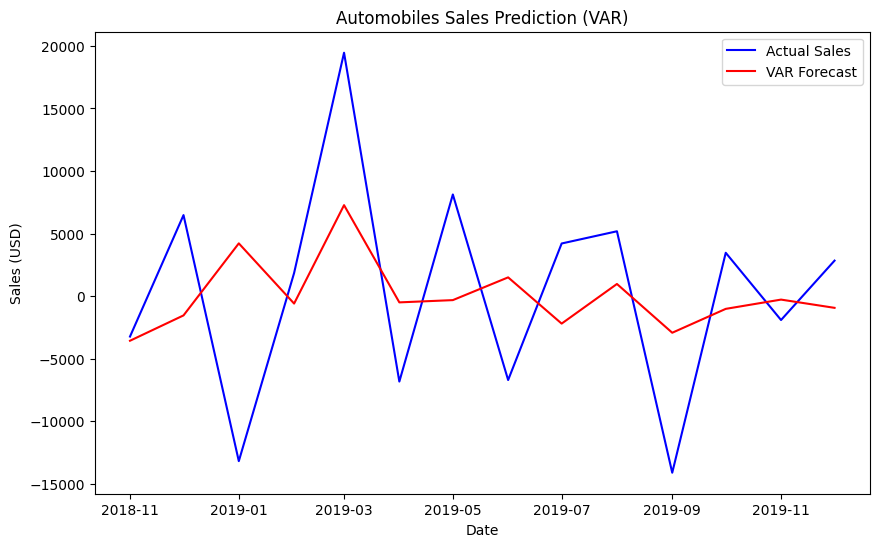

RMSE_VAR: 8115.89


In [195]:
# VAR Model
data = sales_data[['Automobiles', 'BuildingMaterials']].diff().dropna()
train_data_var, test_data_var = data[:-14], data[-14:]
model_var = VAR(train_data_var)
result_var = model_var.fit(maxlags=7)
predictions_var = result_var.forecast(train_data_var.values[-result_var.k_ar:], steps=len(test_data_var))
predictions_var = pd.DataFrame(predictions_var, index=test_data_var.index, columns=test_data_var.columns)

plt.figure(figsize=(10,6))
plt.plot(test_data_var.index, test_data_var['Automobiles'], label='Actual Sales', color='blue')
plt.plot(test_data_var.index, predictions_var['Automobiles'], label='VAR Forecast', color='red')
plt.title('Automobiles Sales Prediction (VAR)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_var = round(np.sqrt(mean_squared_error(test_data_var['Automobiles'], predictions_var['Automobiles'])), 2)
print('RMSE_VAR:', rmse_var)

# VARMAX Model

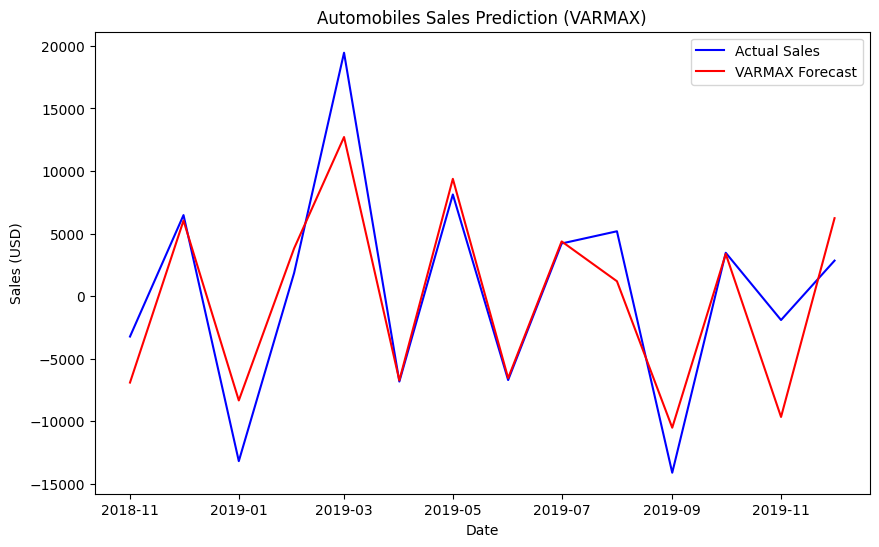

RMSE_VARMAX: 3671.87


In [214]:
# VARMAX Model
model_varmax = VARMAX(train_data_var, order=(14, 14))
result_varmax = model_varmax.fit()
predictions_varmax = result_varmax.predict(
    start=len(train_data_var),
    end=len(train_data_var) + len(test_data_var) - 1,
    dynamic=False
)

plt.figure(figsize=(10,6))
plt.plot(test_data_var.index, test_data_var['Automobiles'], label='Actual Sales', color='blue')
plt.plot(test_data_var.index, predictions_varmax['Automobiles'], label='VARMAX Forecast', color='red')
plt.title('Automobiles Sales Prediction (VARMAX)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()
rmse_varmax = round(np.sqrt(mean_squared_error(test_data_var['Automobiles'], predictions_varmax['Automobiles'])), 2)
print('RMSE_VARMAX:', rmse_varmax)

# Moving Averages

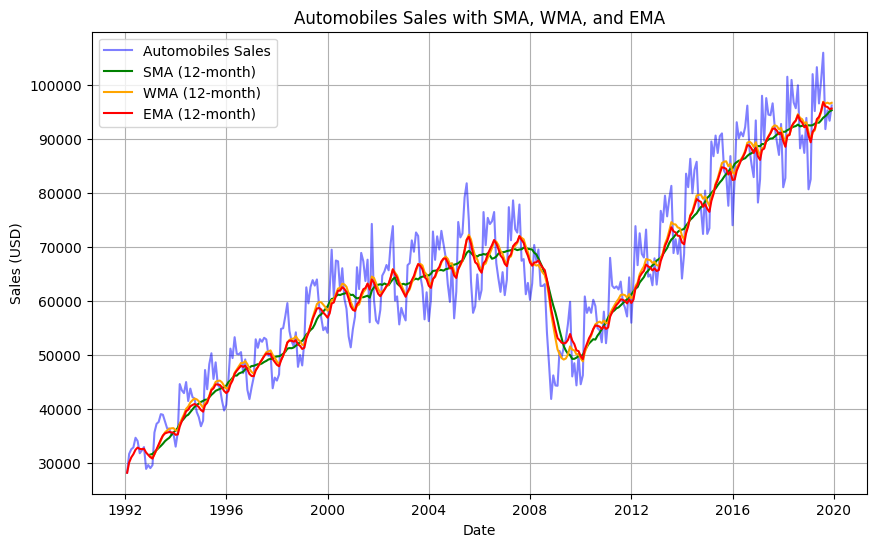

In [167]:
# Moving Averages
window_size = 12
sales_data['SMA'] = sales_data['Automobiles'].rolling(window=window_size).mean()
weights = np.arange(1, window_size + 1)
sales_data['WMA'] = sales_data['Automobiles'].rolling(window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
sales_data['EMA'] = sales_data['Automobiles'].ewm(span=window_size).mean()

plt.figure(figsize=(10,6))
plt.plot(sales_data['Automobiles'], label='Automobiles Sales', color='blue', alpha=0.5)
plt.plot(sales_data['SMA'], label=f'SMA ({window_size}-month)', color='green')
plt.plot(sales_data['WMA'], label=f'WMA ({window_size}-month)', color='orange')
plt.plot(sales_data['EMA'], label=f'EMA ({window_size}-month)', color='red')
plt.title('Automobiles Sales with SMA, WMA, and EMA')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid()
plt.show()

# Exponential Smoothing

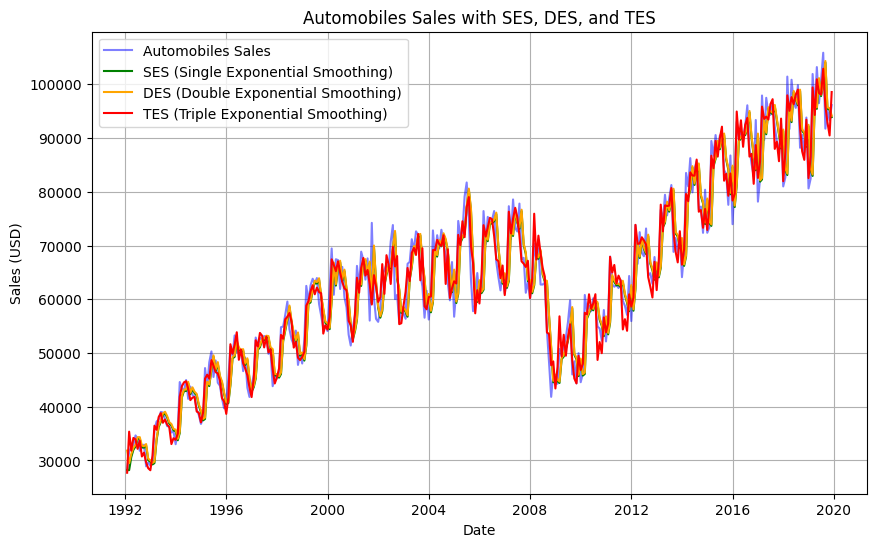

TES MSE: 8043334.53368446
DES MSE: 29176500.865500886
SES MSE: 29238832.40145808


In [180]:
# Smoothing
close_prices = sales_data['Automobiles']
ses_model = SimpleExpSmoothing(close_prices).fit(smoothing_level=0.7)
sales_data['SES'] = ses_model.fittedvalues
des_model = ExponentialSmoothing(close_prices, trend='add').fit(smoothing_level=0.7)
sales_data['DES'] = des_model.fittedvalues
tes_model = ExponentialSmoothing(close_prices, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.6)
sales_data['TES'] = tes_model.fittedvalues

plt.figure(figsize=(10,6))
plt.plot(sales_data['Automobiles'], label='Automobiles Sales', color='blue', alpha=0.5)
plt.plot(sales_data['SES'], label='SES (Single Exponential Smoothing)', color='green')
plt.plot(sales_data['DES'], label='DES (Double Exponential Smoothing)', color='orange')
plt.plot(sales_data['TES'], label='TES (Triple Exponential Smoothing)', color='red')
plt.title('Automobiles Sales with SES, DES, and TES')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid()
plt.show()
tes_mse = mean_squared_error(close_prices, sales_data['TES'])
des_mse = mean_squared_error(close_prices, sales_data['DES'])
ses_mse = mean_squared_error(close_prices, sales_data['SES'])
print('TES MSE:', tes_mse)
print('DES MSE:', des_mse)
print('SES MSE:', ses_mse)

# ACF and PACF Plots

Estimated optimal ARIMA parameters:
 - p (from PACF): 6
 - q (from ACF):  9


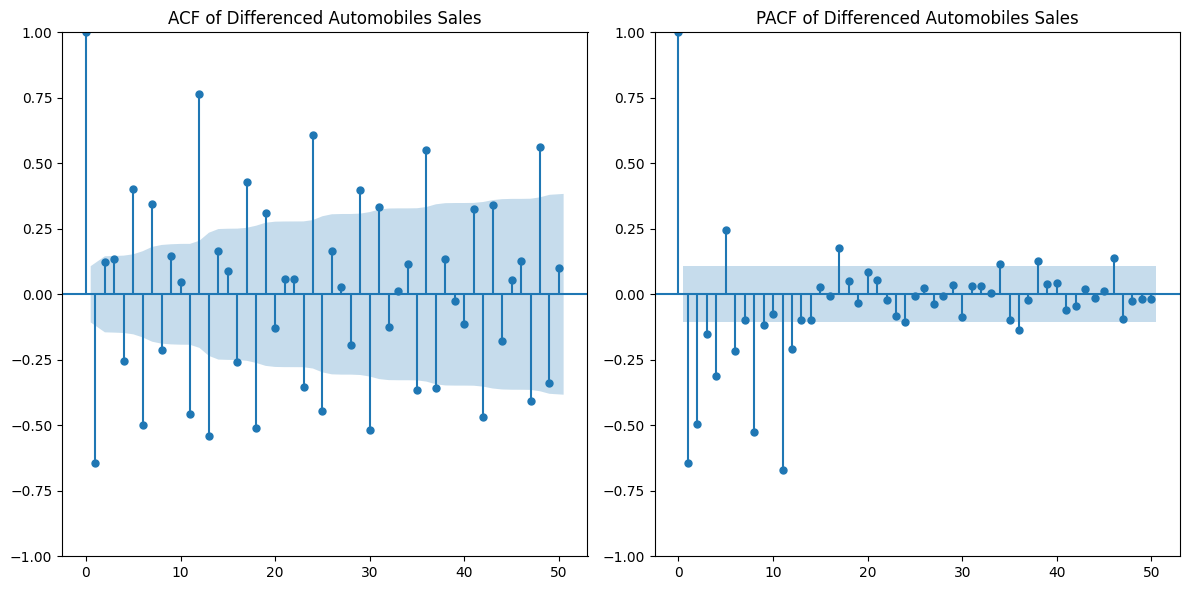

In [190]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf


# ACF and PACF Plots
diff_series = sales_data['Automobiles'].diff().diff().dropna()
n = len(diff_series)
conf_threshold = 1.96 / np.sqrt(n)
acf_vals = acf(diff_series, nlags=50)
pacf_vals = pacf(diff_series, nlags=50, method='ywm')

def find_first_significant_lag(correlations):
    for lag in range(1, len(correlations)):
        if abs(correlations[lag]) < conf_threshold:
            return lag - 1
    return 0

q_est = find_first_significant_lag(acf_vals)
p_est = find_first_significant_lag(pacf_vals)

print(f"Estimated optimal ARIMA parameters:")
print(f" - p (from PACF): {p_est}")
print(f" - q (from ACF):  {q_est}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(diff_series, ax=plt.gca(), lags=50)
plt.title('ACF of Differenced Automobiles Sales')
plt.subplot(1, 2, 2)
plot_pacf(diff_series, ax=plt.gca(), lags=50, method='ywm')
plt.title('PACF of Differenced Automobiles Sales')
plt.tight_layout()
plt.show()

# Model Evaluation Metrics

In [173]:

# Model Evaluation Metrics
mae = mean_absolute_error(test_data, predictions_sarima)
print(f'Mean Absolute Error (MAE): {mae}')
mse = mean_squared_error(test_data, predictions_sarima)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mape = np.mean(np.abs((test_data - predictions_sarima) / test_data)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape} %')
aic = model_fit_sarima.aic
bic = model_fit_sarima.bic
print(f'Akaike Information Criterion (AIC): {aic}')
print(f'Bayesian Information Criterion (BIC): {bic}')

Mean Absolute Error (MAE): 3.604650642345693
Mean Squared Error (MSE): 20.60446843409958
Root Mean Squared Error (RMSE): 4.539214517303581
Mean Absolute Percentage Error (MAPE): 1.195305790689587 %
Akaike Information Criterion (AIC): 1831.8636367540705
Bayesian Information Criterion (BIC): 1894.4265711073606


# SARIMA Forecast for Automobiles Sales (Next 5 Years)

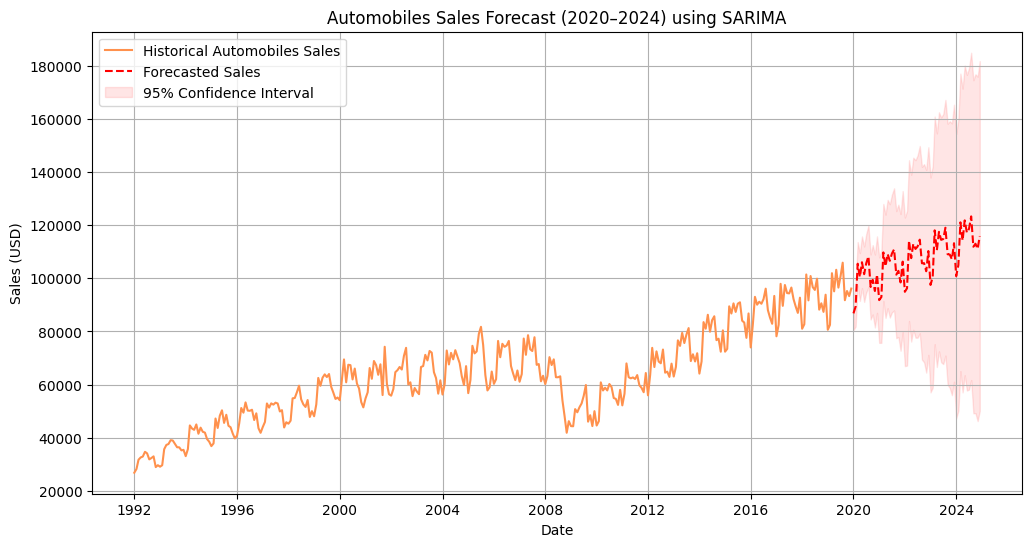


Forecasted Automobiles Sales for the Next 5 Years:
                 Forecast      Lower CI       Upper CI
2020-01-01   86798.372806  80455.071921   93141.673692
2020-02-01   89376.094721  81844.323332   96907.866110
2020-03-01  105491.268492  97317.585658  113664.951327
2020-04-01  100483.954073  91461.317720  109506.590427
2020-05-01  106045.257388  96318.643594  115771.871183
2020-06-01  101546.570380  91097.690324  111995.450436
2020-07-01  105697.694841  94660.129646  116735.260037
2020-08-01  108266.497425  96651.566046  119881.428805
2020-09-01   96739.929126  84495.456276  108984.401977
2020-10-01   99440.133506  86374.948103  112505.318909
2020-11-01   95225.473904  81490.663715  108960.284094
2020-12-01  101382.283521  86978.721022  115785.846021
2021-01-01   91788.367944  75683.003619  107893.732270
2021-02-01   92946.044957  75706.353771  110185.736143
2021-03-01  109745.780568  91484.465343  128007.095793
2021-04-01  104507.742623  85067.149751  123948.335495
2021-05-01  1

In [217]:

"""SARIMA Forecast for Automobiles Sales (Next 5 Years)"""


# Define SARIMA model parameters (same as original code)
p, d, q = 7, 1, 7
P, D, Q, s = 1, 1, 1, 12

# Fit SARIMA model on the entire dataset
model_sarima = SARIMAX(sales_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()

# Forecast for the next 5 years (60 months)
forecast_steps = 60
forecast = model_fit_sarima.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create date index for the forecast period
last_date = sales_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='MS')

# Create DataFrame for forecast results
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=forecast_index)

# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data, label='Historical Automobiles Sales', color='#FF914D')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Sales', color='red', linestyle='--')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='red', alpha=0.1, label='95% Confidence Interval')
plt.title('Automobiles Sales Forecast (2020–2024) using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast values
print("\nForecasted Automobiles Sales for the Next 5 Years:")
print(forecast_df)
